In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
batch_size = 128
train_data = torch.utils.data.DataLoader(
       torchvision.datasets.MNIST('../data',
                     train=True,
                     transform=torchvision.transforms.ToTensor(),
                     download=True),
                     batch_size=batch_size,
                     shuffle=True)

test_data = torch.utils.data.DataLoader(
       torchvision.datasets.MNIST('../data',
                     train=False,
                     transform=torchvision.transforms.ToTensor(),
                     download=True),
                     batch_size=batch_size,
                     shuffle=True)

In [4]:
class Encoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)

        self.proj2mu = nn.Linear(hidden_dims, latent_dims)
        self.proj2sigma = nn.Linear(hidden_dims, latent_dims)

        self.N = torch.distributions.Normal(0, 1)

        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # (B, 784)
        x = F.relu(self.linear1(x)) # (B, 256)
        x = F.relu(self.linear2(x)) # (B, 256)

        mu =  self.proj2mu(x) # (B, 2)
        sigma = torch.exp(self.proj2sigma(x)) # (B, 2)
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 / 2 + mu**2 / 2 - torch.log(sigma) - 1/2).mean()
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, 28*28)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
class VAE(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(VAE, self).__init__()
        self.encoder = Encoder(hidden_dims, latent_dims)
        self.decoder = Decoder(hidden_dims, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
def plot_reconstructed(autoencoder):
    w = 28
    img = np.zeros((2*w, 15*w))
    for batch in train_data:
        test_data_batch_1 = batch
        break
    for i in range(15):
        index = int(torch.rand(1,).item() * len(test_data_batch_1[0]))
        img[0:w,i*w:(i+1)*w] = test_data_batch_1[0][index]
        x = test_data_batch_1[0][index]
        x_hat = autoencoder(x).reshape(28, 28).detach().numpy()
        img[w:2*w,i*w:(i+1)*w] = x_hat
    plt.axis('off')
    plt.imshow(img)

def generate(vae, latent_dim):
    w = 28
    img = np.zeros((1*w, 15*w))
    latent = []
    for i in range(15):
        z = torch.randn(latent_dim,)
        x_hat = vae.decoder(z).reshape(28, 28).detach().numpy()
        img[0:w, i*w:(i+1)*w] = x_hat
        latent.append([z[0].item(), z[1].item()])
    # print(latent)
    plt.axis('off')
    plt.imshow(img)

def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='Set3')
        if i > num_batches:
            plt.colorbar()
            break

In [6]:
hidden_dims, latent_dims = 256, 2
lr = 0.001

def train(epochs, vae, opt):
    ep = []
    train_loss_list = []
    test_loss_list = []
    # train
    
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        for i, (x, y) in enumerate(tqdm(train_data, desc='training')):
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            loss.backward()
            opt.step()
            train_loss += loss

        with torch.no_grad():
            for i, (x, y) in enumerate(tqdm(test_data, desc='val')):
                x_hat_test = vae(x)
                test_loss += ((x - x_hat_test)**2).sum() + vae.encoder.kl

        ep.append(epoch + 1) 
        train_loss_list.append(train_loss.item() / (len(train_data) * batch_size))
        test_loss_list.append(test_loss.item() / (len(train_data) * batch_size))

    plt.title("vae loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    # plt.plot(ep, train_loss_list, 'red', label='training loss')
    plt.plot(ep, test_loss_list, 'blue', label='testing loss')
    plt.legend(loc="upper right")
    plt.show()



In [7]:
vae = VAE(hidden_dims, latent_dims)
vae_2 = VAE(hidden_dims, latent_dims)
vae_3 = VAE(hidden_dims, latent_dims)
vae_4 = VAE(hidden_dims, latent_dims)
vae_5 = VAE(hidden_dims, latent_dims)
vae_6 = VAE(hidden_dims, 32)

vae = torch.load('vae_1.pt')
vae_2 = torch.load('vae_2.pt')
vae_3 = torch.load('vae_3.pt')
vae_4 = torch.load('vae_4.pt')
vae_5 = torch.load('vae_5.pt')
vae_6 = torch.load('vae_6.pt')

## Ep = 1

val: 100%|██████████| 79/79 [00:00<00:00, 84.60it/s]


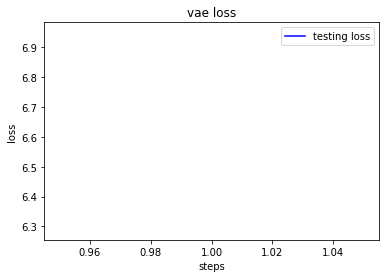

In [8]:
# epoch = 1
vae = VAE(hidden_dims, latent_dims)
opt = torch.optim.Adam(vae.parameters(), lr)
epochs = 1

train(epochs, vae, opt)

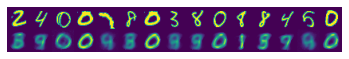

In [9]:
plot_reconstructed(vae)

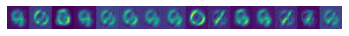

In [10]:
generate(vae, 2)

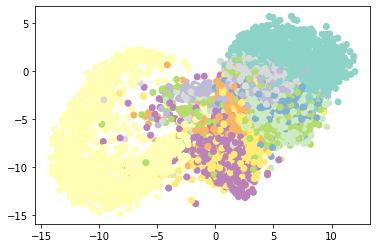

In [8]:
plot_latent(vae, test_data)

# Ep = 5

val: 100%|██████████| 79/79 [00:01<00:00, 60.59it/s]


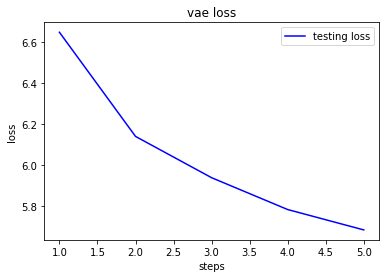

In [14]:
# epoch = 5
vae_2 = VAE(hidden_dims, latent_dims)
opt = torch.optim.Adam(vae_2.parameters(), lr)
epochs = 5

train(epochs, vae_2, opt)

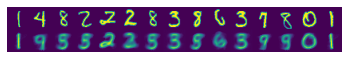

In [12]:
plot_reconstructed(vae_2)

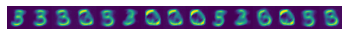

In [13]:
generate(vae_2, 2)

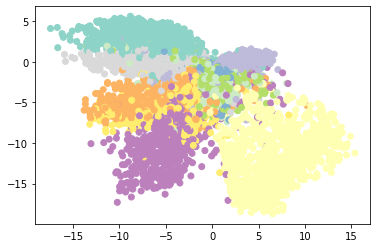

In [14]:
plot_latent(vae_2, test_data)

val: 100%|██████████| 79/79 [00:02<00:00, 37.10it/s]


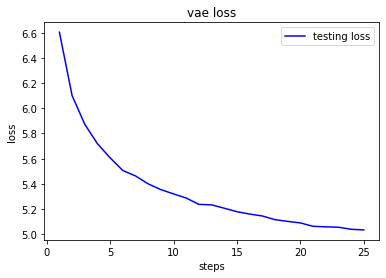

In [23]:
# epoch = 25
vae_3 = VAE(hidden_dims, latent_dims)
opt = torch.optim.Adam(vae_3.parameters(), lr)
epochs = 25

train(epochs, vae_3, opt)

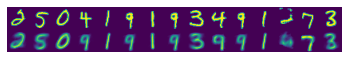

In [15]:
plot_reconstructed(vae_3)

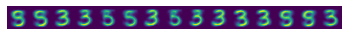

In [16]:
generate(vae_3, 2)

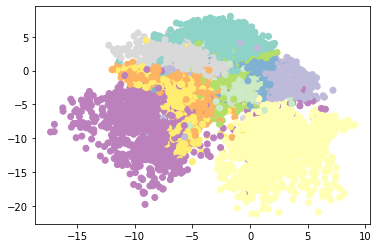

In [17]:
plot_latent(vae_3, test_data)

val: 100%|██████████| 79/79 [00:01<00:00, 66.30it/s]


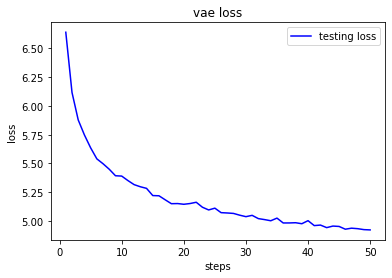

In [27]:
# epoch = 50
vae_4 = VAE(hidden_dims, latent_dims)
opt = torch.optim.Adam(vae_4.parameters(), lr)
epochs = 50

train(epochs, vae_4, opt)

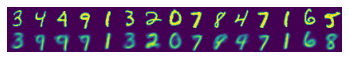

In [18]:
plot_reconstructed(vae_4)

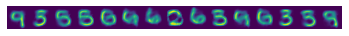

In [19]:
generate(vae_4, 2)

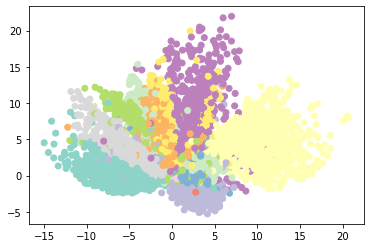

In [20]:
plot_latent(vae_4, test_data)

## Train till convergence

val: 100%|██████████| 79/79 [00:01<00:00, 59.76it/s]


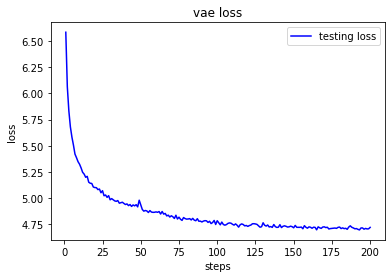

In [31]:
vae_5 = VAE(hidden_dims, latent_dims)
opt = torch.optim.Adam(vae_5.parameters(), lr)
epochs = 200

train(epochs, vae_5, opt)

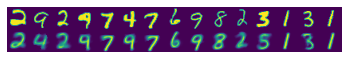

In [21]:
plot_reconstructed(vae_5)

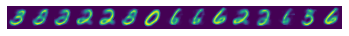

In [22]:
generate(vae_5, 2)

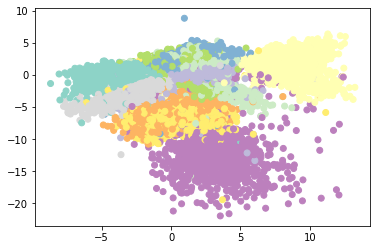

In [25]:
plot_latent(vae_5, test_data)

## Latent_dim = 32

val: 100%|██████████| 79/79 [00:01<00:00, 52.30it/s]


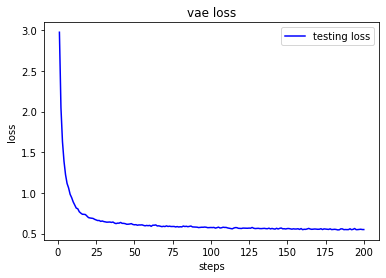

In [35]:
latent_dims = 32
vae_6 = VAE(hidden_dims, latent_dims)
opt = torch.optim.Adam(vae_6.parameters(), lr)
epochs = 200

train(epochs, vae_6, opt)

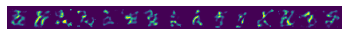

In [14]:
generate(vae_6, 32)